## 3. 승인매출정보

In [7]:
import pandas as pd
from pathlib import Path

In [9]:
import pandas as pd
from pathlib import Path

# 폴더 경로
train_folder = Path(r"C:\Users\apf_temp_admin\Documents\멋사_데이터 분석 5기\프로젝트\2차\data\open\train")

# 회원정보 로드
member_folder = train_folder / "1.회원정보"
member_files = list(member_folder.glob("*.parquet"))

member_dfs = []
for file in member_files:
    df = pd.read_parquet(file)
    member_dfs.append(df[["ID", "Segment", "연령", "남녀구분코드", "Life_Stage"]])

member_df = pd.concat(member_dfs, ignore_index=True).drop_duplicates(subset="ID")
print("✅ 회원정보 로드 완료:", member_df.shape)

# 승인매출정보 로드
approval_folder = train_folder / "3.승인매출정보"
approval_files = list(approval_folder.glob("*.parquet"))

approval_dfs = []
for file in approval_files:
    df = pd.read_parquet(file)
    approval_dfs.append(df)

approval_df = pd.concat(approval_dfs, ignore_index=True)
print("✅ 승인매출정보 로드 완료:", approval_df.shape)

✅ 회원정보 로드 완료: (400000, 5)
✅ 승인매출정보 로드 완료: (2400000, 406)


In [11]:
# Segment Merge
merged_df = pd.merge(
    approval_df,
    member_df[["ID", "Segment", "연령", "남녀구분코드", "Life_Stage"]],
    on="ID",
    how="left"
)

print("✅ 승인매출정보 + Segment 병합 완료:", merged_df.shape)

✅ 승인매출정보 + Segment 병합 완료: (2400000, 410)


In [15]:
# 1️⃣ 이용금액대 앞번호 제거
merged_df["이용금액대_정제"] = merged_df["이용금액대"].str.replace(r"^\d+\.", "", regex=True)

# 2️⃣ 세그먼트별 이용금액대별 고객수 집계
result = (
    merged_df.groupby(["Segment", "이용금액대_정제"])
    .size()
    .reset_index(name="고객수")
)

# 3️⃣ 세그먼트별 총합 계산
segment_total = (
    result.groupby("Segment")["고객수"].sum().reset_index(name="총고객수")
)

# 4️⃣ 총합 merge
result = result.merge(segment_total, on="Segment", how="left")

# 5️⃣ 비율 계산
result["비율(%)"] = (result["고객수"] / result["총고객수"] * 100).round(2)

# 6️⃣ 정렬
result = result.sort_values(["Segment", "고객수"], ascending=[True, False])

# 7️⃣ 출력
print(result)


   Segment 이용금액대_정제     고객수     총고객수   비율(%)
0        A   100만원+     972      972  100.00
1        B   100만원+     144      144  100.00
2        C   100만원+   96886   127590   75.94
6        C    50만원+   14398   127590   11.28
3        C    10만원+    4778   127590    3.74
4        C    10만원-    4338   127590    3.40
7        C      미사용    4119   127590    3.23
5        C    30만원+    3071   127590    2.41
8        D   100만원+  163368   349242   46.78
12       D    50만원+  106111   349242   30.38
9        D    10만원+   24120   349242    6.91
10       D    10만원-   19950   349242    5.71
11       D    30만원+   18547   349242    5.31
13       D      미사용   17146   349242    4.91
19       E      미사용  466254  1922052   24.26
16       E    10만원-  438705  1922052   22.82
18       E    50만원+  340042  1922052   17.69
15       E    10만원+  304789  1922052   15.86
17       E    30만원+  279488  1922052   14.54
14       E   100만원+   92774  1922052    4.83


In [17]:
# 세그먼트별 평균 계산
segment_avg = (
    merged_df.groupby("Segment")["이용건수_신용_R6M"]
    .mean()
    .round(2)
    .sort_values(ascending=False)
)

#  전체 평균 계산
overall_avg = merged_df["이용건수_신용_R6M"].mean().round(2)

# 3️비율 계산 (각 세그먼트 평균 ÷ 전체 평균 × 100)
ratio = (segment_avg / overall_avg * 100).round(1)

# 4️데이터프레임으로 정리
result_df = (
    pd.DataFrame({
        "평균 이용건수_신용_R6M": segment_avg,
        "전체 평균 대비 비율(%)": ratio
    })
)

# 5️출력
print("✅ 최근 6개월 누적 세그먼트별 평균 이용건수 및 비율")
print(result_df)

✅ 최근 6개월 누적 세그먼트별 평균 이용건수 및 비율
         평균 이용건수_신용_R6M  전체 평균 대비 비율(%)
Segment                                
B                342.17           372.9
A                326.97           356.3
C                235.22           256.3
D                182.50           198.9
E                 65.63            71.5


In [19]:
# 세그먼트별 평균 이용건수 계산
result = (
    merged_df.groupby("Segment")["이용건수_체크_R6M"]
    .mean()
    .round(2)
    .sort_values(ascending=False)
)

print("✅ 최근 6개월 누적 세그먼트별 평균 이용건수_체크_R6M")
print(result)

✅ 최근 6개월 누적 세그먼트별 평균 이용건수_체크_R6M
Segment
C    43.95
D    38.22
B    32.28
E    10.43
A    10.13
Name: 이용건수_체크_R6M, dtype: float64


In [21]:
# 세그먼트별 평균 이용건수 계산
result = (
    merged_df.groupby("Segment")["이용건수_카드론_R6M"]
    .mean()
    .round(2)
    .sort_values(ascending=False)
)

print("✅ 최근 6개월 누적 세그먼트별 평균 이용건수_카드론_R6M")
print(result)

✅ 최근 6개월 누적 세그먼트별 평균 이용건수_카드론_R6M
Segment
A    0.04
C    0.03
D    0.02
E    0.02
B    0.00
Name: 이용건수_카드론_R6M, dtype: float64


In [23]:
# 합계 컬럼 계산
merged_df["신용합계"] = (
    merged_df["이용금액_일시불_R6M"].fillna(0) +
    merged_df["이용금액_할부_R6M"].fillna(0) +
    merged_df["이용금액_CA_R6M"].fillna(0)
)

# 세그먼트별 평균 계산
result_credit = (
    merged_df.groupby("Segment")["신용합계"]
    .mean()
    .round(2)
    .sort_values(ascending=False)
)

result_check = (
    merged_df.groupby("Segment")["이용금액_체크_R6M"]
    .mean()
    .round(2)
    .sort_values(ascending=False)
)

# 출력
print("✅ 최근 6개월 누적 세그먼트별 평균 신용카드 (일시불+할부+CA) 이용금액")
print(result_credit)

print("\n✅ 최근 6개월 누적 세그먼트별 평균 체크카드 이용금액")
print(result_check)

✅ 최근 6개월 누적 세그먼트별 평균 신용카드 (일시불+할부+CA) 이용금액
Segment
B    194558.88
A    179216.07
C    100343.43
D     59913.87
E     17712.55
Name: 신용합계, dtype: float64

✅ 최근 6개월 누적 세그먼트별 평균 체크카드 이용금액
Segment
C    9803.39
D    8222.37
B    6844.49
A    2287.92
E    2172.51
Name: 이용금액_체크_R6M, dtype: float64


In [27]:
from IPython.display import display

# 각 항목 평균 구하기
credit_means = (
    merged_df.groupby("Segment")[["이용금액_일시불_R6M", "이용금액_할부_R6M", "이용금액_CA_R6M", "신용합계"]]
    .mean()
    .round(2)
)

# 비율 계산
credit_means["일시불 비중(%)"] = (credit_means["이용금액_일시불_R6M"] / credit_means["신용합계"] * 100).round(2)
credit_means["할부 비중(%)"]   = (credit_means["이용금액_할부_R6M"] / credit_means["신용합계"] * 100).round(2)
credit_means["CA 비중(%)"]     = (credit_means["이용금액_CA_R6M"] / credit_means["신용합계"] * 100).round(2)

# 보기 좋게 정렬
credit_means = credit_means.sort_values("신용합계", ascending=False)

# 컬럼명 보기 좋게 바꾸기
credit_means = credit_means.rename(columns={
    "이용금액_일시불_R6M": "일시불 평균",
    "이용금액_할부_R6M": "할부 평균",
    "이용금액_CA_R6M": "CA 평균",
    "신용합계": "신용카드 총 평균"
})

# 표시
display(credit_means.style.format("{:,.2f}").set_caption("✅ 세그먼트별 최근 6개월 평균 신용카드 이용금액 및 비중"))

,일시불 평균,할부 평균,CA 평균,신용카드 총 평균,일시불 비중(%),할부 비중(%),CA 비중(%)
Segment,,,,,,,
B,"104,606.99","32,599.44","57,352.46","194,558.88",53.77,16.76,29.48
A,"114,670.54","20,870.03","43,675.50","179,216.07",63.98,11.65,24.37
C,"70,802.25","10,458.94","19,082.24","100,343.43",70.56,10.42,19.02
D,"45,821.53","7,387.81","6,704.53","59,913.87",76.48,12.33,11.19
E,"14,166.86","2,457.42","1,088.26","17,712.55",79.98,13.87,6.14


In [41]:
# 세그먼트별 업종별 건수 집계
counts = (
    merged_df.groupby(["Segment", "_1순위업종"])
    .size()
    .reset_index(name="건수")
)

# 세그먼트별 업종별 평균 이용금액
amounts = (
    merged_df.groupby(["Segment", "_1순위업종"])["_1순위업종_이용금액"]
    .mean()
    .round(2)
    .reset_index(name="평균이용금액")
)

# 합치기
result = pd.merge(counts, amounts, on=["Segment", "_1순위업종"])
result = result.sort_values(["Segment", "건수"], ascending=[True, False])

# 보기 좋게 출력
segments = result["Segment"].unique()

for seg in segments:
    print(f"\n🔹 Segment {seg}")
    seg_data = result[result["Segment"] == seg]
    for _, row in seg_data.iterrows():
        업종 = row["_1순위업종"]
        건수 = row["건수"]
        금액 = row["평균이용금액"]
        print(f"{업종}: {건수}건 / 평균이용금액 {금액:,.0f}만원")


🔹 Segment A
쇼핑: 797건 / 평균이용금액 47,000만원
사교활동: 50건 / 평균이용금액 15,300만원
의료: 40건 / 평균이용금액 19,137만원
교육: 24건 / 평균이용금액 17,071만원
납부: 21건 / 평균이용금액 4,184만원
교통: 18건 / 평균이용금액 3,190만원

🔹 Segment B
쇼핑: 142건 / 평균이용금액 49,262만원
의료: 2건 / 평균이용금액 8,148만원

🔹 Segment C
쇼핑: 93116건 / 평균이용금액 22,798만원
납부: 8059건 / 평균이용금액 3,597만원
사교활동: 7565건 / 평균이용금액 10,705만원
교통: 5217건 / 평균이용금액 2,352만원
교육: 4010건 / 평균이용금액 12,723만원
의료: 2109건 / 평균이용금액 11,879만원
해외: 1147건 / 평균이용금액 1,760만원
여유생활: 59건 / 평균이용금액 2,083만원
일상생활: 4건 / 평균이용금액 400만원

🔹 Segment D
쇼핑: 235162건 / 평균이용금액 14,491만원
납부: 31840건 / 평균이용금액 3,499만원
사교활동: 22194건 / 평균이용금액 7,532만원
교통: 18622건 / 평균이용금액 2,418만원
교육: 13005건 / 평균이용금액 10,664만원
해외: 3238건 / 평균이용금액 1,565만원
의료: 2839건 / 평균이용금액 8,362만원
여유생활: 144건 / 평균이용금액 1,743만원
일상생활: 12건 / 평균이용금액 382만원

🔹 Segment E
쇼핑: 701573건 / 평균이용금액 6,672만원
납부: 371412건 / 평균이용금액 1,936만원
교통: 167572건 / 평균이용금액 1,701만원
사교활동: 70480건 / 평균이용금액 3,428만원
교육: 59574건 / 평균이용금액 10,092만원
해외: 22351건 / 평균이용금액 1,428만원
의료: 15153건 / 평균이용금액 3,950만원
여유생활: 2166건 / 평균이용금액 1,104

In [66]:
# 세그먼트별 정상청구 평균
normal_mean = (
    merged_df.groupby("Segment")["정상청구원금_B0M"]
    .mean()
    .round(2)
    .reset_index(name="평균_정상청구원금")
)

# 세그먼트별 연체입금 평균
arrears_mean = (
    merged_df.groupby("Segment")["연체입금원금_B0M"]
    .mean()
    .round(2)
    .reset_index(name="평균_연체입금원금")
)

# 합치기
result = pd.merge(normal_mean, arrears_mean, on="Segment")

# 연체율 계산
result["연체율(%)"] = (
    result["평균_연체입금원금"] / result["평균_정상청구원금"] * 100
).round(2)

# 출력
print("✅ 당월 세그먼트별 청구/연체 정보")
print(result)


✅ 당월 세그먼트별 청구/연체 정보
  Segment  평균_정상청구원금  평균_연체입금원금  연체율(%)
0       A   37794.28    3662.33    9.69
1       B   36986.01    8971.98   24.26
2       C   18517.79    4914.94   26.54
3       D   10263.20    2443.91   23.81
4       E    3175.57     731.79   23.04


TypeError: can only concatenate tuple (not "list") to tuple

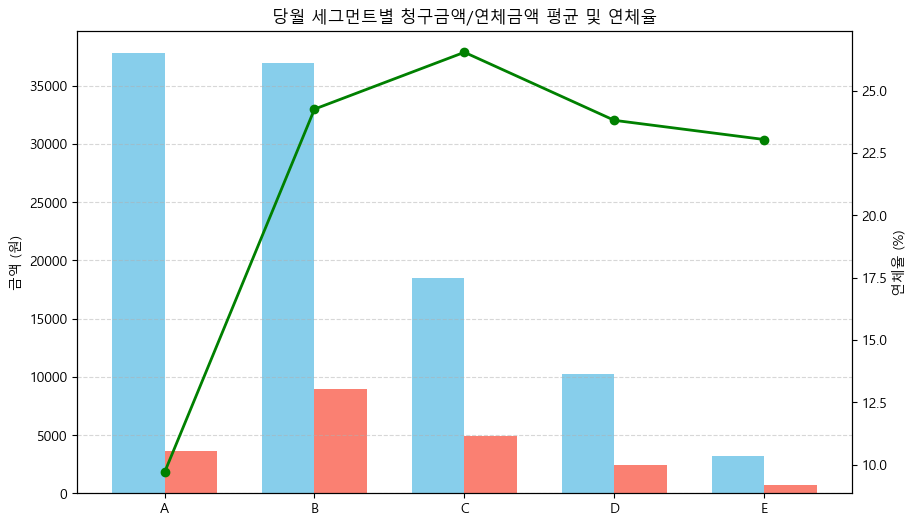

In [67]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

fig, ax1 = plt.subplots(figsize=(10,6))

# X축 위치
x = range(len(result))
width = 0.35

# 왼쪽 Y축 - 막대그래프 (금액)
bar1 = ax1.bar(
    [i - width/2 for i in x],
    result["평균_정상청구원금"],
    width=width,
    label="평균 정상청구원금",
    color="skyblue"
)
bar2 = ax1.bar(
    [i + width/2 for i in x],
    result["평균_연체입금원금"],
    width=width,
    label="평균 연체입금원금",
    color="salmon"
)

ax1.set_ylabel("금액 (원)")
ax1.set_xticks(x)
ax1.set_xticklabels(result["Segment"])
ax1.grid(axis="y", linestyle="--", alpha=0.5)

# 오른쪽 Y축 - 꺾은선그래프 (연체율)
ax2 = ax1.twinx()
line = ax2.plot(
    x,
    result["연체율(%)"],
    color="green",
    marker="o",
    linewidth=2,
    label="연체율 (%)"
)
ax2.set_ylabel("연체율 (%)")

# 제목
plt.title("당월 세그먼트별 청구금액/연체금액 평균 및 연체율")

# 범례
bars = bar1 + bar2
labels = [b.get_label() for b in bars]
lines_labels = [line[0].get_label()]
ax1.legend(bars + line, labels + lines_labels, loc="upper left")

plt.show()

## 4. 청구입금정보

In [11]:
import pandas as pd

member_df = pd.read_csv(
    r"C:\Users\apf_temp_admin\Documents\멋사_데이터 분석 5기\프로젝트\2차\data\open\train\train_1회원정보.csv",
    encoding="utf-8-sig")

In [12]:
billing_df = pd.read_csv(
    r"C:\Users\apf_temp_admin\Documents\멋사_데이터 분석 5기\프로젝트\2차\data\open\train\train_4청구입금정보.csv",
    encoding="utf-8-sig"
)

billing_with_segment = pd.merge(
    billing_df,
    member_df[["ID", "Segment", "연령", "남녀구분코드", "Life_Stage"]],
    on="ID",
    how="left"
)

print("✅ 청구정보 + Segment 병합 완료:", billing_with_segment.shape)

✅ 청구정보 + Segment 병합 완료: (14400000, 51)


In [17]:
result = (
    billing_with_segment.groupby(["Segment", "대표청구서수령지구분코드"])
    .size()
    .reset_index(name="고객수")
)

pivot_table = result.pivot_table(
    index="Segment",
    columns="대표청구서수령지구분코드",
    values="고객수",
    fill_value=0
)

pivot_table = pivot_table.astype(int)

print(pivot_table)

대표청구서수령지구분코드  K톡명세서+이메일  당사멤버십+이메일  당사페이앱+이메일  문자메세지     미수신       우편      이메일
Segment                                                                       
A                    60          0        336      0      36     2658     2742
B                    18          0        126      0       0      288      432
C                 18078         54      67668      0   12222   327750   339768
D                 52470         30     225420      0   36480   950724   830328
E                161712        162    1165764      6  195804  6403290  3605574


In [19]:
# 세그먼트별 평균 계산
result = (
    billing_with_segment.groupby("Segment")["포인트_적립포인트_R3M"]
    .mean()
    .round(2)
    .sort_values(ascending=False)
)

print("✅ 세그먼트별 포인트_적립포인트_R3M 평균")
print(result)


✅ 세그먼트별 포인트_적립포인트_R3M 평균
Segment
B    4792.42
C    2983.22
A    2634.70
D    2578.17
E     958.11
Name: 포인트_적립포인트_R3M, dtype: float64


In [21]:
# 세그먼트별, 할인건수_R3M 구간별 고객수 카운트
result = (
    billing_with_segment
    .groupby(["Segment", "할인건수_R3M"])
    .size()
    .reset_index(name="고객수")
    .sort_values(["Segment", "할인건수_R3M"])
)

# 출력
from IPython.display import display
display(result)

,Segment,할인건수_R3M,고객수
0,A,10회 이상,594
1,A,1회 이상,5166
2,A,20회 이상,72
3,B,10회 이상,150
4,B,1회 이상,684
5,B,20회 이상,30
6,C,10회 이상,145350
7,C,1회 이상,554796
8,C,20회 이상,53136
9,C,30회 이상,12252


In [23]:
# 세그먼트별 연체건수_R6M 평균 계산
result = (
    billing_with_segment
    .groupby("Segment")["연체건수_R6M"]
    .mean()
    .round(2)
    .sort_values(ascending=False)
)

print("✅ 6개월 누적 세그먼트별 연체건수_R6M 평균")
print(result)

✅ 6개월 누적 세그먼트별 연체건수_R6M 평균
Segment
B    0.81
C    0.60
D    0.60
A    0.42
E    0.40
Name: 연체건수_R6M, dtype: float64


## 5. 잔액정보
- 연체 데이터 확인 불가

In [26]:
# 잔액정보 로드
balance_df = pd.read_csv(
    r"C:\Users\apf_temp_admin\Documents\멋사_데이터 분석 5기\프로젝트\2차\data\open\train\train_5잔액정보.csv",
    encoding="utf-8-sig"
)

# 병합
balance_with_segment = pd.merge(
    balance_df,
    member_df[["ID", "Segment", "연령", "남녀구분코드", "Life_Stage"]],
    on="ID",
    how="left"
)

print("✅ 잔액정보 + Segment 병합 완료:", balance_with_segment.shape)

✅ 잔액정보 + Segment 병합 완료: (14400000, 87)


In [28]:
# 세그먼트별 RV_평균잔액_R6M 평균
result = (
    balance_with_segment.groupby("Segment")["RV_평균잔액_R6M"]
    .mean()
    .round(2)
    .sort_values(ascending=False)
)

print("✅ 세그먼트별 RV_평균잔액_R6M 평균")
print(result)

✅ 세그먼트별 RV_평균잔액_R6M 평균
Segment
D    798.46
C    675.50
A    504.93
B    463.75
E    288.83
Name: RV_평균잔액_R6M, dtype: float64


In [32]:
# 세그먼트별 RV_최대잔액_R6M 최대값
result = (
    balance_with_segment.groupby("Segment")["RV_최대잔액_R6M"]
    .max()
    .sort_values(ascending=False)
)

print("✅ 세그먼트별 RV_최대잔액_R6M 최대값")
print(result)

✅ 세그먼트별 RV_최대잔액_R6M 최대값
Segment
E    79564
C    68415
D    63333
A    26274
B    15922
Name: RV_최대잔액_R6M, dtype: int64


In [36]:
# 세그먼트별 RV_잔액이월횟수_R6M 평균
result = (
    balance_with_segment.groupby("Segment")["RV잔액이월횟수_R6M"]
    .mean()
    .round(2)
    .sort_values(ascending=False)
)

print("✅ 세그먼트별 RV_잔액이월횟수_R6M 평균")
print(result)

✅ 세그먼트별 RV_잔액이월횟수_R6M 평균
Segment
A    0.0
B    0.0
C    0.0
D    0.0
E    0.0
Name: RV잔액이월횟수_R6M, dtype: float64


# Segment별 특성 분석

In [33]:
import pandas as pd

# 세그먼트 요약 데이터프레임
summary_df = pd.DataFrame({
    "Segment": ["A", "B", "C", "D", "E"],
    "고객수 비중(%)": [0.04, 0.01, 5.3, 14.5, 80.0],
    "100만원+ 이용 비중(%)": [100, 100, 76, 47, 5],
    "신용카드 평균금액(만원)": [179216, 194558, 100343, 59914, 17713],
    "평균 신용카드 건수": [327, 342, 235, 182, 66],
    "평균 체크카드 금액(만원)": [2287, 6844, 9803, 8222, 2172],
    "연체율(%)": [9.7, 24.3, 26.5, 23.8, 23.0],
    "평균 연체건수": [0.42, 0.81, 0.60, 0.60, 0.40],
    "RV 평균잔액(만원)": [504, 463, 675, 798, 288]
})

# 출력
from IPython.display import display
display(summary_df)

,Segment,고객수 비중(%),100만원+ 이용 비중(%),신용카드 평균금액(만원),평균 신용카드 건수,평균 체크카드 금액(만원),연체율(%),평균 연체건수,RV 평균잔액(만원)
0,A,0.04,100,179216,327,2287,9.7,0.42,504
1,B,0.01,100,194558,342,6844,24.3,0.81,463
2,C,5.30,76,100343,235,9803,26.5,0.60,675
3,D,14.50,47,59914,182,8222,23.8,0.60,798
4,E,80.00,5,17713,66,2172,23.0,0.40,288
